In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib widget

df = pd.read_csv("eval_ckpt2150(2).csv")
df

,i,pos0,pos1,pos2,pos3,pos4,pos5,pos6,vel0,vel1,...,obs6,obs7,obs8,obs9,obs10,obs11,obs12,obs13,obs14,obs15
0,0,0.000019,-0.000580,0.080135,0.843145,0.459294,-0.216132,3.854067,0.009131,-0.112068,...,-0.459755,-0.418835,0.091310,-1.120677,0.253719,-0.351890,0.385407,0.410028,0.912073,0.0
1,1,0.000226,-0.001690,0.079817,0.839871,0.422841,-0.212410,3.683401,0.030527,-0.109426,...,-0.434818,-0.412238,0.305268,-1.094258,-0.837118,-0.331726,0.368340,0.410028,0.912073,0.0
2,2,0.000625,-0.002761,0.078404,0.836976,0.387692,-0.209712,3.522569,0.047732,-0.104728,...,-0.411166,-0.403596,0.477318,-1.047285,-1.935815,-0.312496,0.352257,0.410028,0.912073,0.0
3,3,0.001176,-0.003777,0.075891,0.834283,0.353901,-0.207840,3.371135,0.061076,-0.098619,...,-0.388479,-0.392860,0.610756,-0.986186,-3.036091,-0.294084,0.337113,0.410028,0.912073,0.0
4,4,0.001842,-0.004728,0.072279,0.831672,0.321527,-0.206631,3.228710,0.070967,-0.091620,...,-0.366564,-0.380178,0.709668,-0.916205,-4.133385,-0.276416,0.322871,0.410028,0.912073,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,-2.778659,0.697023,0.085031,-1.909651,-0.805631,-1.948333,103.067543,0.211030,-0.602252,...,-0.745542,0.015650,2.110296,-6.022524,-0.996602,-0.119654,10.306754,0.080301,-0.996771,0.0
1996,1996,-2.775731,0.690572,0.082900,-1.859168,-0.799978,-1.983116,103.114052,0.368660,-0.680990,...,-0.111871,0.077506,3.686599,-6.809898,-3.132021,0.284933,10.311405,0.080301,-0.996771,0.0
1997,1997,-2.772759,0.684360,0.079945,-1.812644,-0.795320,-2.020817,103.152351,0.230770,-0.569691,...,-0.741526,-0.018450,2.307697,-5.696908,-2.821909,-0.111445,10.315235,0.080301,-0.996771,0.0
1998,1998,-2.771190,0.679092,0.077315,-1.829379,-0.772881,-2.106391,102.994202,0.089769,-0.497887,...,-1.372654,-0.228863,0.897685,-4.978873,-2.387769,-0.503089,10.299420,0.080301,-0.996771,0.0


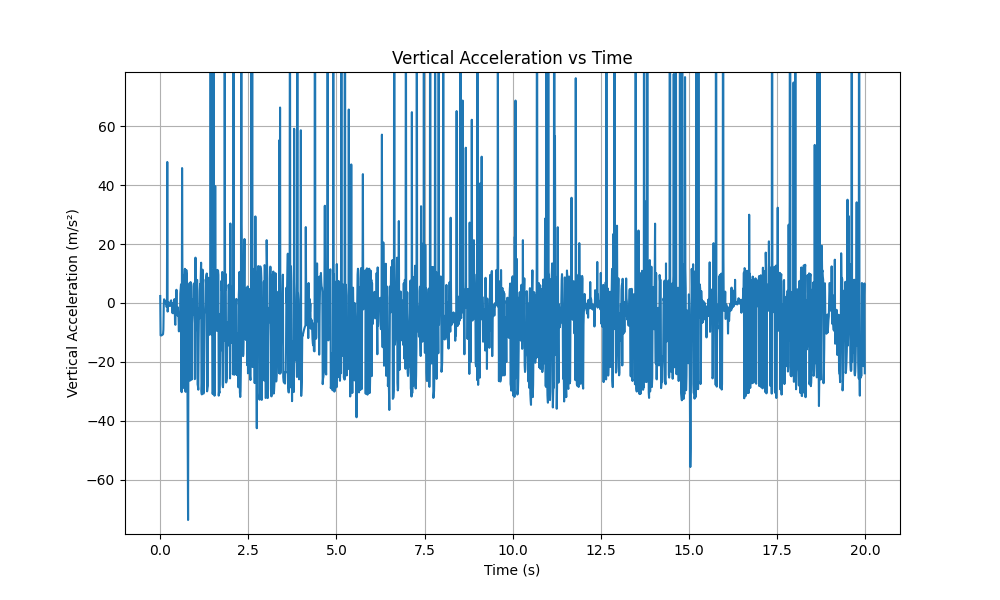

In [5]:
# Create time array using dt=0.01
time = np.arange(len(df)) * 0.01

# Plot vertical acceleration (acc2) over time
plt.figure(figsize=(10,6))
plt.plot(time, df['acc2'])
plt.xlabel('Time (s)')
plt.ylabel('Vertical Acceleration (m/s²)')
plt.title('Vertical Acceleration vs Time')
plt.grid(True)
plt.ylim(-9.8*8, 9.8*8)
plt.show()


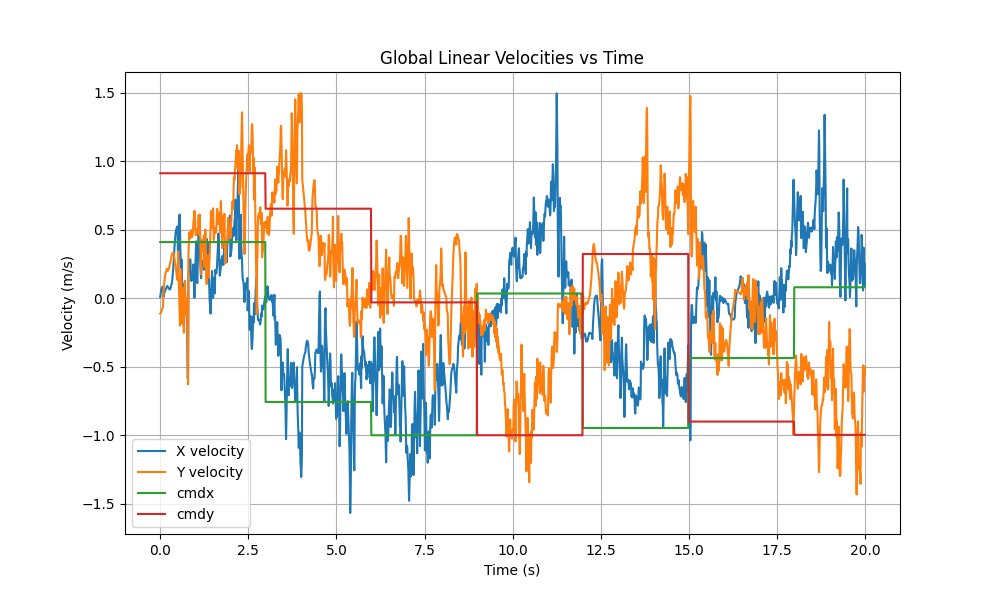

In [9]:
# Plot global linear velocities
plt.figure(figsize=(10,6))
plt.plot(time, df['vel0'], label='X velocity')
plt.plot(time, df['vel1'], label='Y velocity') 
plt.plot(time, df['obs13'], label='cmdx')
plt.plot(time, df['obs14'], label='cmdy')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Global Linear Velocities vs Time')
plt.legend()
plt.grid(True)
plt.show()


X velocity residual: 0.6422
Y velocity residual: 0.9855


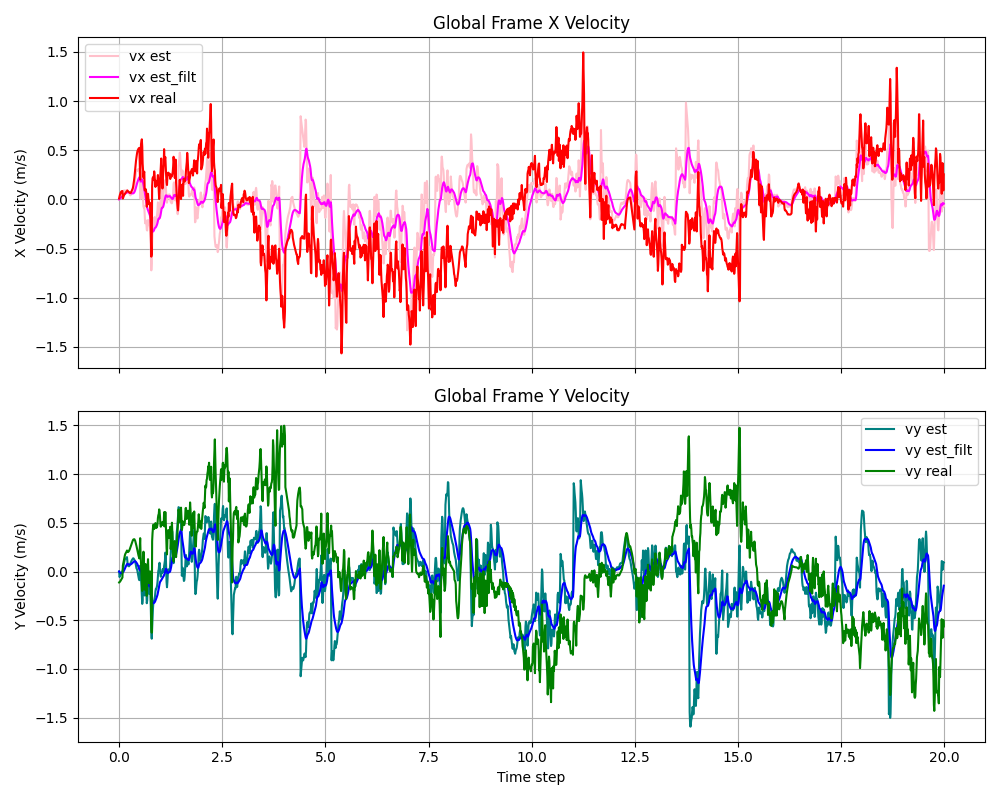

In [78]:
PI = np.pi
robot_quats = np.array([df['quat0'], df['quat1'], df['quat2'], df['quat3']]).T
robot_poss = np.array([df['pos0'], df['pos1'], df['pos2']]).T
global_lin_accs = np.array([df['acc0'], df['acc1'], df['acc2']]).T
global_ang_accs = np.array([df['acc3'], df['acc4'], df['acc5']]).T
global_ang_vels = np.array([df['vel3'], df['vel4'], df['vel5']]).T


p_imu_base = np.array([-0.02989, 0.06366, -0.0032])


# Initialize arrays to store results
imu_acc_globals = np.zeros((len(df), 3))
imu_acc_locals = np.zeros((len(df), 3))
v_global_est = np.zeros((len(df), 3))

v_global_est_filt = np.zeros_like(v_global_est)

for i in range(len(df)):
# for i in range(10):
    robot_pos = robot_poss[i]
    robot_quat = robot_quats[i]
    global_lin_acc = global_lin_accs[i] 
    global_ang_acc = global_ang_accs[i]
    global_ang_vel = global_ang_vels[i]

    imu_acc_global = (
        global_lin_acc
        + np.cross(global_ang_acc, p_imu_base)  # Coriolis term
        + np.cross(global_ang_vel, np.cross(global_ang_vel, p_imu_base))  # Centripetal term
    )


    # Create 4x4 transformation matrix from base position and quaternion
    T_base = np.eye(4)
    qw, qx, qy, qz = robot_quat
    T_base[:3,:3] = np.array([
        [1-2*qy*qy-2*qz*qz, 2*qx*qy-2*qz*qw, 2*qx*qz+2*qy*qw],
        [2*qx*qy+2*qz*qw, 1-2*qx*qx-2*qz*qz, 2*qy*qz-2*qx*qw],
        [2*qx*qz-2*qy*qw, 2*qy*qz+2*qx*qw, 1-2*qx*qx-2*qy*qy]
    ])
    T_base[:3,3] = robot_pos

    # Create 4x4 transformation matrix from IMU position and rotation
    T_imu_translate = np.eye(4)
    T_imu_translate[:3,3] = p_imu_base   # Set translation vector


    x_rot_imu = np.array([
        [1, 0, 0],
        [0, np.cos(PI), -np.sin(PI)],
        [0, np.sin(PI), np.cos(PI)],
    ])
    z_rot_imu = np.array([
        [np.cos(PI/2), -np.sin(PI/2), 0],
        [np.sin(PI/2), np.cos(PI/2), 0],
        [0, 0, 1]
    ])
    R_imu = x_rot_imu @ z_rot_imu
    T_imu_rotate = np.eye(4)
    T_imu_rotate[:3,:3] = R_imu  # Set rotation block

    T_imu = T_base @ T_imu_translate @ T_imu_rotate
    R_imu = T_imu[:3, :3]  # IMU rotation in global frame

    g = np.array([0, 0, -9.81])
    imu_acc_local = R_imu.T @ (imu_acc_global - g)
    imu_acc_locals[i] = imu_acc_local

    imu_pos = T_imu[:3,3]

    # print("T_base:\n", T_base)
    # print("T_imu:\n", T_imu)
    # print("robot_pos:\n", robot_pos)
    # print("imu_pos:\n", imu_pos)

    # print(dist)
    # print("robot_quat:\n", robot_quat)
    
    if i >= 1:
        dt = 0.01
        decay = 0.95
        v_global_est[i] = v_global_est[i-1]*decay + 0.5*(global_lin_accs[i]+global_lin_accs[i-1])*dt

        v_global_est_filt[i] = 0.1*v_global_est[i] + 0.9*v_global_est_filt[i-1]
    # if np.linalg.norm(global_lin_acc) < 10:
    #     v_global_est[i] = np.zeros(3)

    
# Plot velocity estimates
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8), sharex=True)

# X velocity subplot
ax1.plot(time, v_global_est[:,0], 'pink', label='vx est')
ax1.plot(time, v_global_est_filt[:,0], 'magenta', label='vx est_filt')
ax1.plot(time, df['vel0'], 'red', label='vx real')
ax1.set_ylabel('X Velocity (m/s)')
ax1.set_title('Global Frame X Velocity')
ax1.legend()
ax1.grid(True)

# Y velocity subplot
ax2.plot(time, v_global_est[:,1], 'teal', label='vy est')
ax2.plot(time, v_global_est_filt[:,1], 'blue', label='vy est_filt')
ax2.plot(time, df['vel1'], 'green', label='vy real')
ax2.set_xlabel('Time step')
ax2.set_ylabel('Y Velocity (m/s)') 
ax2.set_title('Global Frame Y Velocity')
ax2.legend()
ax2.grid(True)

plt.tight_layout()

# Calculate residuals (sum of squared differences)
x_residual = np.sum((v_global_est[:,0] - df['vel0'])**2)/np.sum((df['vel0'])**2)
y_residual = np.sum((v_global_est[:,1] - df['vel1'])**2)/np.sum((df['vel1'])**2)

print(f"X velocity residual: {x_residual:.4f}")
print(f"Y velocity residual: {y_residual:.4f}")





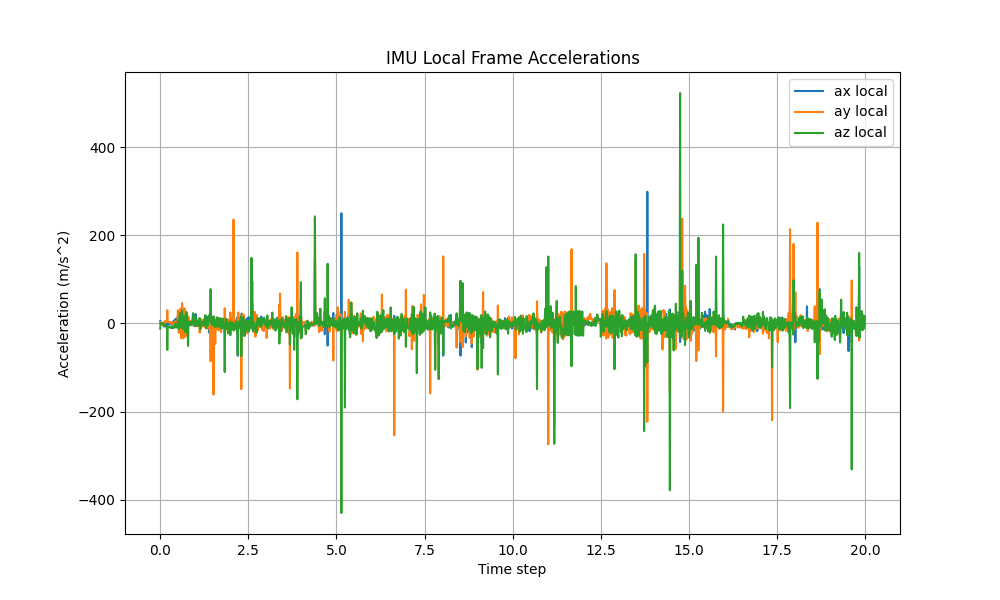

In [41]:
# Plot IMU accelerations
plt.figure(figsize=(10,6))
plt.plot(time, imu_acc_locals[:,0], label='ax local')
plt.plot(time, imu_acc_locals[:,1], label='ay local')
plt.plot(time, imu_acc_locals[:,2], label='az local')
plt.xlabel('Time step') 
plt.ylabel('Acceleration (m/s^2)')
plt.title('IMU Local Frame Accelerations')
plt.legend()
plt.grid(True)
